## Titanic

[Titanic on Kaggle](https://www.kaggle.com/c/titanic/overview)

Predict survival on the Titanic and get familiar with ML basics

#### Load dependencies

In [1]:
# This will help us to measure the time it took for the whole
# notebook to execute
import time
start_time = time.time()

import os
import importlib
import sys
sys.path.append('../../utils')
import datasets
importlib.reload(datasets)
import helpers
importlib.reload(helpers)

# Allows plot inside jupyer notebooks
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd

import sklearn
from sklearn.pipeline import Pipeline               # Allows you to create a sequence of transformations and a final estimator in a single, cohesive workflow
from sklearn.impute import SimpleImputer            # Used to fill in missing values in your dataset.
from sklearn.preprocessing import StandardScaler    # Standardizes features by removing the mean and scaling them to unit variance
from sklearn.preprocessing import OneHotEncoder     # Used to encode categorical variables as one-hot (or dummy) variables.
from sklearn.compose import ColumnTransformer       # Allows you to apply different transformations to different columns within a DataFrame
from sklearn.ensemble import RandomForestClassifier # Builds an ensemble of decision trees, averaging their predictions to reduce overfitting.
from sklearn.model_selection import cross_val_score # Provides robust model evaluation by using multiple train-test splits, leading to a more accurate estimate of model performance.
from sklearn.svm import SVC                         # A powerful classification algorithm that uses hyperplanes to separate classes, particularly effective in high-dimensional spaces or with complex class boundaries.

#### Get Titanic dataset

In [2]:
TITANIC_PATH = os.path.join("../../datasets", "titanic")
DOWNLOAD_URL = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/titanic/"
DATASET_FILES = ["train.csv", "test.csv"]

datasets.download(DOWNLOAD_URL, TITANIC_PATH, DATASET_FILES)
train_data = datasets.load_csv(TITANIC_PATH, DATASET_FILES[0])
test_data = datasets.load_csv(TITANIC_PATH, DATASET_FILES[1])

train.csv is already downloaded.
test.csv is already downloaded.


#### Dataset preview

The attributes have the following meaning:

| Attribute | Meaning | Key |
|:---|:---|:---|
| PassengerId | Unique identifier | |
| Survived | Indicates if passenger survived | 0 = No, 1 = Yes |
| Pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd |
| Name | Name of the passanger | |
| Sex | Sex of the passanger | |
| Age | Age in years | |
| SibSp | # of siblings / spouses aboard the Titanic | |
| Parch | # of parents / children aboard the Titanic | |
| Ticket | Ticket number | |
| Fare | Passenger fare | |
| Cabin | Cabin number | |
| Embarked | Port of embarkation | C = Cherbourg, Q = Queenstown, S = Southampton |

In [3]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
# Set "PassengerId" as the index column
train_data = train_data.set_index("PassengerId")
test_data = test_data.set_index("PassengerId")

In [6]:
# Review data and see if anything is missing
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [7]:
# Calculate the median age of females passengers
train_data[train_data["Sex"]=="female"]["Age"].median()

np.float64(27.0)

In [8]:
# Numerical attributes
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


#### Validate more data

Validate some other attributes.

In [9]:
train_data["Survived"].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

In [10]:
train_data["Pclass"].value_counts()

Pclass
3    491
1    216
2    184
Name: count, dtype: int64

In [11]:
train_data["Sex"].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

In [12]:
train_data["Embarked"].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

#### Preprocessing pipeline

Preprocessing pipeline that takes the raw data and outputs numerical input features that we can feed to any Machine Learning model we want.

In [13]:
# Pipeline for numerical attributes
num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

# Pipeline for categorical attributes
cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse_output=False)),
    ])

# Join pipelines
num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

# Adding labels
y_train = train_data["Survived"]

# Preview
X_train = preprocess_pipeline.fit_transform(
    train_data[num_attribs + cat_attribs])
X_train

array([[-0.56573582,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.6638609 ,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.10463705,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276213, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]])

#### Train a classifier

In [14]:
# Train the model
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [15]:
# Make predictions on the test set
X_test = preprocess_pipeline.transform(test_data[num_attribs + cat_attribs])
y_pred = forest_clf.predict(X_test)

In [16]:
# Cross-validate the model
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

np.float64(0.8160049937578027)

In [17]:
# Try with an SVC
svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

np.float64(0.8249313358302123)

#### Plot models

The random forest classifier got a very high score on one of the 10 folds, but overall it had a lower mean score, as well as a bigger spread, so it looks like the SVM classifier is more likely to generalize well.

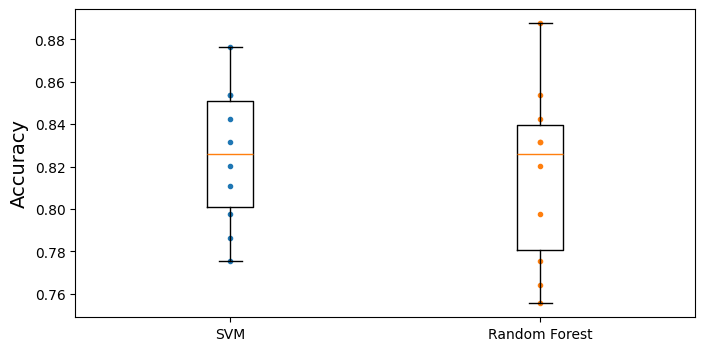

In [18]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], tick_labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

---

## Total Time

This show the total time of execution

In [19]:
# Sets the total time of execution
end_time = time.time()
helpers.calculate_execution_time(start_time, end_time)

Total execution time: 0.0 minutes and 2.47 seconds
